<a href="https://colab.research.google.com/github/malekzitouni/Generative-AI-with-diffusion-Models/blob/main/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contrastive Language-Image Pre-Training or [CLIP](https://github.com/openai/CLIP/tree/main) is a text and image encoding tool used with many popular Generative AI models such as [DALL-E](https://openai.com/dall-e-2) and [Stable Diffusion](https://github.com/Stability-AI/stablediffusion).

In [2]:
import csv
import glob
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid
from textwrap import wrap

# User defined libraries
from utils import other_utils
from utils import ddpm_utils
from utils import UNet_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
! conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

/bin/bash: line 1: conda: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-x95ixc20
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-x95ixc20
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=fee14bdb04c33af757f71b7655fd9ad35dc4df0497627ea354c2d1d95d47aee7
  Stored in directory: /tmp/pip-ephem-wheel-cache-bkza7far/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


In [8]:
import torch
import clip
from PIL import Image

In [9]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [10]:
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512

100%|███████████████████████████████████████| 338M/338M [00:19<00:00, 18.1MiB/s]


In [25]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("/content/sky.JPG")).unsqueeze(0).to(device)
text = clip.tokenize(["a sky", "an elephant", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print(image_features.shape)
print(text_features.shape)


torch.Size([1, 512])
torch.Size([3, 512])


In [26]:
print(image_features)

tensor([[-7.5558e-02,  9.2379e-02, -5.1515e-01,  2.5916e-02,  3.3126e-01,
         -6.7511e-03, -3.0885e-01,  6.9476e-01,  1.9389e-01,  2.8092e-01,
         -1.0640e-01, -2.5877e-01,  1.1196e-01, -3.2971e-01, -6.5430e-03,
         -4.4421e-02, -3.5722e-02,  1.0791e-01,  5.7081e-02, -5.6835e-02,
          8.3500e-02,  1.7981e-01,  3.2155e-02, -1.2785e-01,  4.8187e-01,
         -4.2928e-01,  3.3219e-01,  9.1168e-02,  2.4451e-01, -6.6988e-02,
         -9.2276e-02,  3.4719e-01, -2.9419e-01,  3.5998e-01,  7.1918e-02,
         -4.0950e-02, -1.4223e-01,  2.4230e-01, -2.5417e-01,  3.7749e-01,
          6.1533e-01, -1.3102e-02, -1.3874e-01,  2.8216e-01,  6.2985e-02,
         -9.1280e-01, -3.0111e-01,  5.0053e-02, -8.4715e-02, -2.4333e-01,
          4.6554e-01, -5.0853e-02,  2.0811e-01, -1.1592e-01, -3.7100e-01,
          3.5338e-01,  2.3803e-01,  1.3126e-01,  6.6420e-02,  8.7079e-02,
          2.3667e-01, -5.0156e-02,  6.3683e-01,  2.1468e-01, -5.2264e-01,
         -4.3078e-01, -8.7960e-02,  4.

In [27]:
print(text_features)

tensor([[-0.0489,  0.1002,  0.1435,  ..., -0.5787,  0.0367,  0.1954],
        [ 0.0281,  0.0130,  0.0031,  ..., -0.1264, -0.0087,  0.0908],
        [ 0.1981, -0.2040, -0.1533,  ..., -0.4514, -0.5664,  0.0596]])


In [28]:
print(probs) # Highest Probability: Indicates the most likely description for the image.

[[0.98408616 0.01438734 0.00152664]]


In [29]:
clip_preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7988bab68f40>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [54]:
DATA_DIR = "/content/drive/MyDrive/flower_photos"
img_path = DATA_DIR + "/daisy/2877860110_a842f8b14a_m.jpg"
img = Image.open(img_path)
img.show()

In [55]:
clip_imgs = torch.tensor(np.stack([clip_preprocess(img)])).to(device)
clip_imgs.size()

torch.Size([1, 3, 224, 224])

In [56]:
clip_img_encoding = clip_model.encode_image(clip_imgs)
print(clip_img_encoding.size())
#clip_img_encoding
print(clip_img_encoding)

torch.Size([1, 512])
tensor([[-2.7214e-01, -1.4328e-02, -1.7886e-01, -2.6783e-02, -6.9681e-01,
          9.4821e-02,  3.2449e-01, -7.8665e-02,  4.3896e-01,  4.6977e-01,
          4.1920e-01,  1.1126e-01, -5.0402e-01, -1.2042e-01,  7.8546e-02,
         -3.2473e-01,  7.2856e-01,  2.4036e-02,  2.4047e-02, -5.0267e-01,
         -5.6677e-01,  1.7865e-01, -3.8932e-01, -3.2533e-01,  1.4539e-02,
         -3.2320e-03,  1.2952e-01, -2.4094e-01,  1.0989e-01, -4.9972e-01,
          9.0573e-02,  2.3577e-01,  2.5464e-01, -7.0967e-03,  2.5057e-02,
          1.6715e-02,  1.4913e-01, -4.1984e-01, -1.0153e-01,  1.1167e+00,
         -2.5138e-01, -3.1246e-02,  1.9025e-01,  9.8161e-02,  7.0564e-01,
         -4.1994e-01,  1.3688e-02,  2.0309e-01, -1.3564e-01,  1.6415e-01,
         -2.6067e-01,  3.6526e-01, -3.5492e-02, -6.0212e-01, -1.0922e-01,
         -2.8157e-01,  4.5030e-03, -5.3388e-01, -1.1362e-01,  4.3514e-02,
          1.1818e+00,  1.5167e-01,  2.9804e-01, -3.5360e-01, -2.3564e-02,
         -9.2078e

In [57]:
text_list = [
    "A round white daisy with a yellow center",
    "An orange sunflower with a big brown center",
    "A red rose bud"
]
text_tokens = clip.tokenize(text_list).to(device)
text_tokens
#The token ID 0 corresponds to a special padding token in the CLIP vocabulary.


tensor([[49406,   320,  2522,  1579, 12865,   593,   320,  4481,  2119, 49407,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   550,  4287, 21559,   593,   320,  1205,  2866,  2119, 49407,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

In [58]:
clip_text_encodings = clip_model.encode_text(text_tokens).float()
print(clip_text_encodings.size())
#clip_text_encodings

torch.Size([3, 512])


In [59]:
print(clip_text_encodings)

tensor([[-0.5111,  0.1915,  0.1967,  ...,  0.0946, -0.0848, -0.2787],
        [ 0.0227,  0.3892,  0.3511,  ...,  0.1215,  0.0780, -0.1917],
        [-0.3942,  0.1264,  0.3798,  ...,  0.0193,  0.0152, -0.3430]],
       grad_fn=<MmBackward0>)


In [60]:
import clip
print(clip.__file__)


/usr/local/lib/python3.11/dist-packages/clip/__init__.py


In order to see which one of our text descriptions best describes the daisy, we can calculate the [cosine similarity](https://medium.com/@milana.shxanukova15/cosine-distance-and-cosine-similarity-a5da0e4d9ded) between the text encodings and the image encodings. When the cosine similarity is `1`, it's a perfect match. When the cosine similarity is `-1`, the two encodings are opposites.

The cosine similarity is equivalent to a [dot product](https://mathworld.wolfram.com/DotProduct.html) with each vector normalized by their magnitude. In other words, the magnitude of each vector becomes `1`.

We can use the following formula to calculate the dot product:

$X \cdot Y = \sum_{i=1}^{n} x_i y_i = x_1y_1 + x_2 y_2 + \cdots  + x_n y_n$

In [61]:
clip_img_encoding /= clip_img_encoding.norm(dim=-1, keepdim=True)
clip_text_encodings /= clip_text_encodings.norm(dim=-1, keepdim=True)
similarity = (clip_text_encodings * clip_img_encoding).sum(-1)
similarity

tensor([0.3707, 0.2474, 0.1770], grad_fn=<SumBackward1>)

In [62]:
for idx, text in enumerate(text_list):
    print(text, " - ", similarity[idx])

A round white daisy with a yellow center  -  tensor(0.3707, grad_fn=<SelectBackward0>)
An orange sunflower with a big brown center  -  tensor(0.2474, grad_fn=<SelectBackward0>)
A red rose bud  -  tensor(0.1770, grad_fn=<SelectBackward0>)


In [77]:
img_paths = [
    DATA_DIR + "/roses/8032328803_30afac8b07_m.jpg",
    DATA_DIR + "/sunflowers/2721638730_34a9b7a78b.jpg",
    DATA_DIR + "/daisy/2877860110_a842f8b14a_m.jpg"
]

imgs = [Image.open(path) for path in img_paths]
for img in imgs:
    img.show()

In [78]:
def get_img_encodings(imgs):
    processed_imgs = [clip_preprocess(img) for img in imgs]
    clip_imgs = torch.tensor(np.stack(processed_imgs)).to(device)
    clip_img_encodings = clip_model.encode_image(clip_imgs)
    return clip_img_encodings

In [80]:
clip_img_encodings = get_img_encodings(imgs)
print(clip_img_encodings.shape)
print(clip_img_encodings)

torch.Size([3, 512])
tensor([[-0.1206,  0.5822, -0.0638,  ...,  0.3098,  0.3313,  0.1142],
        [ 0.1433, -0.0862, -0.2559,  ...,  0.5141,  0.2074, -0.0046],
        [-0.2721, -0.0143, -0.1789,  ...,  0.5821,  0.0866, -0.1446]],
       grad_fn=<MmBackward0>)


In [81]:
text_list = [
    "A daisy",
    "A sunflower",
    "A rose"
]

In [82]:
text_tokens = clip.tokenize(text_list).to(device)
clip_text_encodings = clip_model.encode_text(text_tokens).float()
clip_text_encodings

tensor([[-0.2876, -0.1920,  0.1515,  ..., -0.2300,  0.0574, -0.1426],
        [ 0.0702,  0.0193,  0.2166,  ..., -0.2564, -0.1206,  0.1393],
        [-0.2049,  0.2699,  0.2398,  ..., -0.5177, -0.0798, -0.2933]],
       grad_fn=<MmBackward0>)

In [83]:
clip_img_encodings /= clip_img_encodings.norm(dim=-1, keepdim=True)
clip_text_encodings /= clip_text_encodings.norm(dim=-1, keepdim=True)

n_imgs = len(imgs)
n_text = len(text_list)
clip_text_encodings

tensor([[-0.0296, -0.0197,  0.0156,  ..., -0.0236,  0.0059, -0.0147],
        [ 0.0074,  0.0020,  0.0228,  ..., -0.0269, -0.0127,  0.0146],
        [-0.0199,  0.0262,  0.0233,  ..., -0.0503, -0.0077, -0.0285]],
       grad_fn=<DivBackward0>)

In [84]:
clip_img_encodings

tensor([[-0.0113,  0.0544, -0.0060,  ...,  0.0290,  0.0310,  0.0107],
        [ 0.0123, -0.0074, -0.0219,  ...,  0.0440,  0.0177, -0.0004],
        [-0.0247, -0.0013, -0.0162,  ...,  0.0529,  0.0079, -0.0131]],
       grad_fn=<DivBackward0>)

In [85]:
repeated_clip_text_encodings = clip_text_encodings.repeat(n_imgs, 1)
repeated_clip_text_encodings

tensor([[-0.0296, -0.0197,  0.0156,  ..., -0.0236,  0.0059, -0.0147],
        [ 0.0074,  0.0020,  0.0228,  ..., -0.0269, -0.0127,  0.0146],
        [-0.0199,  0.0262,  0.0233,  ..., -0.0503, -0.0077, -0.0285],
        ...,
        [-0.0296, -0.0197,  0.0156,  ..., -0.0236,  0.0059, -0.0147],
        [ 0.0074,  0.0020,  0.0228,  ..., -0.0269, -0.0127,  0.0146],
        [-0.0199,  0.0262,  0.0233,  ..., -0.0503, -0.0077, -0.0285]],
       grad_fn=<RepeatBackward0>)

In [86]:
repeated_clip_img_encoding = clip_img_encodings.repeat_interleave(n_text, dim=0)
repeated_clip_img_encoding


tensor([[-0.0113,  0.0544, -0.0060,  ...,  0.0290,  0.0310,  0.0107],
        [-0.0113,  0.0544, -0.0060,  ...,  0.0290,  0.0310,  0.0107],
        [-0.0113,  0.0544, -0.0060,  ...,  0.0290,  0.0310,  0.0107],
        ...,
        [-0.0247, -0.0013, -0.0162,  ...,  0.0529,  0.0079, -0.0131],
        [-0.0247, -0.0013, -0.0162,  ...,  0.0529,  0.0079, -0.0131],
        [-0.0247, -0.0013, -0.0162,  ...,  0.0529,  0.0079, -0.0131]],
       grad_fn=<ViewBackward0>)

In [87]:
print(repeated_clip_text_encodings.shape)
print(repeated_clip_img_encoding.shape)

torch.Size([9, 512])
torch.Size([9, 512])


In [88]:
similarity = (repeated_clip_text_encodings * repeated_clip_img_encoding).sum(-1)
similarity = torch.unflatten(similarity, 0, (n_text, n_imgs))
similarity

tensor([[0.2212, 0.1963, 0.3134],
        [0.2444, 0.2950, 0.1986],
        [0.3259, 0.2695, 0.2329]], grad_fn=<ViewBackward0>)

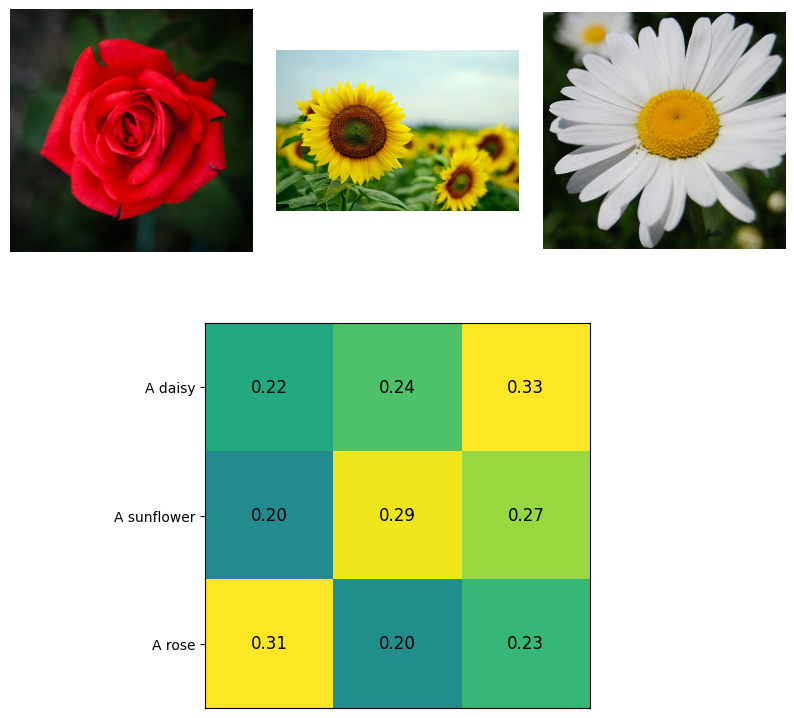

In [89]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 3, wspace=.1, hspace=0)

for i, img in enumerate(imgs):
    ax = fig.add_subplot(gs[0, i])
    ax.axis("off")
    plt.imshow(img)

ax = fig.add_subplot(gs[1, :])
plt.imshow(similarity.detach().cpu().numpy().T, vmin=0.1, vmax=0.3)

labels = [ '\n'.join(wrap(text, 20)) for text in text_list ]
plt.yticks(range(n_text), labels, fontsize=10)
plt.xticks([])

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[x, y]:.2f}", ha="center", va="center", size=12)

In the previous notebook, we used the flower category as the label. This time, we're going to use CLIP encodings as our label.

If the goal of CLIP is to align text encodings with image encodings, do we need a text description for each of the images in our dataset? Hypothesis: we do not need text descriptions and only need the image CLIP encodings to create a text-to-image pipeline.

To test this out, let's add the CLIP encodings as the "label" to our dataset. Running CLIP on each batch of data augmented images would be more accurate, but it is also slower. We can speed things up by preprocessing and storing the encodings ahead of time.

We can use [glob](https://docs.python.org/3/library/glob.html) to list all of our image filepaths:

In [90]:
data_paths = glob.glob(DATA_DIR + '*/*.jpg', recursive=True)
data_paths[:5]

[]

In [91]:
csv_path = 'clip.csv'

with open(csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for idx, path in enumerate(data_paths):
        img = Image.open(path)
        clip_img = torch.tensor(np.stack([clip_preprocess(img)])).to(device)
        label = clip_model.encode_image(clip_img)[0].tolist()
        writer.writerow([path] + label)

In [92]:
IMG_SIZE = 32 # Due to stride and pooling, must be divisible by 2 multiple times
IMG_CH = 3
BATCH_SIZE = 128
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)

pre_transforms = [
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
]
pre_transforms = transforms.Compose(pre_transforms)
random_transforms = [
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
]
random_transforms = transforms.Compose(random_transforms)

In [93]:
class MyDataset(Dataset):
    def __init__(self, csv_path, preprocessed_clip=True):
        self.imgs = []
        self.preprocessed_clip = preprocessed_clip
        if preprocessed_clip:
            self.labels = torch.empty(
                len(data_paths), CLIP_FEATURES, dtype=torch.float, device=device
            )

        with open(csv_path, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for idx, row in enumerate(reader):
                img = Image.open(row[0])
                self.imgs.append(pre_transforms(img).to(device))
                if preprocessed_clip:
                    label = [float(x) for x in row[1:]]
                    self.labels[idx, :] = torch.FloatTensor(label).to(device)

    def __getitem__(self, idx):
        img = random_transforms(self.imgs[idx])
        if self.preprocessed_clip:
            label = self.labels[idx]
        else:
            batch_img = img[None, :, :, :]
            encoded_imgs = clip_model.encode_image(clip_preprocess(batch_img))
            label = encoded_imgs.to(device).float()[0]
        return img, label

    def __len__(self):
        return len(self.imgs)